<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Natural%20Language%20Processing/Text_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pathlib
import shutil
import string
import re
import pandas as pd
import matplotlib.pyplot as plt

## Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

**Download and explore the IMDB dataset**

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset_dir = tf.keras.utils.get_file('aclImdb', url, untar=True, cache_dir='.', cache_subdir='')

84140032/84125825 [==============================] - 2s 0us/step


In [3]:
parent_dir = pathlib.Path(dataset_dir).parent
print('parent directory :',parent_dir)

# list all directory in parent dir
print('\n list all folders in parent directory')
for item in parent_dir.iterdir():
  print(item)

# movie review dataset
print('\n list all folders in movie review dataset directory')
movie_review_dir = parent_dir/'aclImdb'
for item in movie_review_dir.iterdir():
  if item.is_dir():
    print(item)

# training dataset
print('\n list all folders in training directory')
train_dir = movie_review_dir/'train'
for item in train_dir.iterdir():
  if item.is_dir():
    print(item)

# testing dataset
print('\n list all folders in testing directory')
test_dir = movie_review_dir/'test'
for item in test_dir.iterdir():
  if item.is_dir():
    print(item)

parent directory : .

 list all folders in parent directory
.config
aclImdb.tar.gz
aclImdb
sample_data

 list all folders in movie review dataset directory
aclImdb/train
aclImdb/test

 list all folders in training directory
aclImdb/train/neg
aclImdb/train/pos
aclImdb/train/unsup

 list all folders in testing directory
aclImdb/test/neg
aclImdb/test/pos


Load the dataset
Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows.

<br>
main_directory/<br>
...class_a/<br>
......a_text_1.txt<br>
......a_text_2.txt<br>
...class_b/<br>
......b_text_1.txt<br>
......b_text_2.txt<br>
<br>
To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [4]:
remove_dir = train_dir/'unsup'
print('Directory to remove:', remove_dir)

Directory to remove: aclImdb/train/unsup


In [5]:
shutil.rmtree(remove_dir)

In [6]:
# training dataset
print('\n list all folders in training directory')
train_dir = movie_review_dir/'train'
for item in train_dir.iterdir():
  if item.is_dir():
    print(item)


 list all folders in training directory
aclImdb/train/neg
aclImdb/train/pos


Use the utility `tf.keras.preprocessing.text_dataset_from_directory` to generate a labeled `tf.data.Dataset` object from a set of text files on disk filed into class-specific folders.

Let's use it to generate the training, validation, and test datasets. The validation and training datasets are generated from two subsets of the train directory, with 20% of samples going to the validation dataset and 80% going to the training dataset.

Having a validation dataset in addition to the test dataset is useful for tuning hyperparameters, such as the model architecture, for which the test dataset should not be used.

Before putting the model out into the real world however, it should be retrained using all available training data (without creating a validation dataset), so its performance is maximized.

When using the `validation_split` & `subset` arguments, make sure to either specify a `random seed`, or to pass `shuffle=False`, so that the validation & training splits you get have no overlap.

## Constants

In [7]:
# constants
BATCH_SIZE = 32
RANDOM_SEED = 42
# Model constants.
max_features = 10000
embedding_dim = 16
sequence_length = 250

In [8]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(train_dir,
                                                                  batch_size=BATCH_SIZE,
                                                                  seed=RANDOM_SEED,
                                                                  validation_split=0.2,
                                                                  subset='training')

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(train_dir,
                                                                batch_size=BATCH_SIZE,
                                                                seed=RANDOM_SEED,
                                                                validation_split=0.2,
                                                                subset='validation')

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(test_dir,
                                                                  batch_size=BATCH_SIZE,
                                                                 )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
print('Train',tf.data.experimental.cardinality(raw_train_ds))
print('Validation',tf.data.experimental.cardinality(raw_val_ds))
print('Test',tf.data.experimental.cardinality(raw_test_ds))

Train tf.Tensor(625, shape=(), dtype=int64)
Validation tf.Tensor(157, shape=(), dtype=int64)
Test tf.Tensor(782, shape=(), dtype=int64)


## Prepare the data
using `preprocessing.TextVectorization` layer.
* Standardize 
* Tokenize
* Vectorize  

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

The reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.




In [10]:
def custom_standardizer(text):
  lowercase = tf.strings.lower(text)
  stripped_html = tf.strings.regex_replace(lowercase, "<[^>]+>", " ")
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), "")

In [11]:
# eg: working of custom standardization
sample_text_batch, sample_label_batch = next(iter(raw_train_ds))
print('Sample text ', sample_text_batch[0].numpy())
print('Sample after standardization', custom_standardizer(sample_text_batch[0]).numpy())

Sample text  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Sample after standardization b'pandemonium is a horror movie spoof that comes off more stupid than funny believe me when i tell you i love comedies especially comedy spoofs airplane the naked gun trilogy blazing saddles high anxie

Now that we have our custom standardization, we can instantiate our text vectorization layer. We are using this layer to normalize, split, and map strings to integers, so we set our 'output_mode' to 'int'.

Note that we're using the default split function,
and the custom standardization defined above.
We also set an explicit maximum sequence length, since the CNNs later in our
model won't support ragged sequences.

In [12]:
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = max_features,
                                                                               standardize = custom_standardizer,
                                                                               output_mode='int',
                                                                               output_sequence_length = sequence_length)

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [13]:
# call adapt on a text only dataset
# Note: it's important to only use your training data when calling adapt (using the test set would leak information).
text_ds = raw_train_ds.map(lambda text, label:text)
vectorize_layer.adapt(text_ds)

## Two options to vectorize the data
There are 2 ways we can use our text vectorization layer:

* Option 1: Make it part of the model, so as to obtain a model that processes raw strings, like this:

<br>
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')<br>
x = vectorize_layer(text_input)<br>
x = layers.Embedding(max_features + 1, embedding_dim)(x)<br>
...<br>
<br>

* Option 2: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs.


An important difference between the two is that option 2 enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So if you're training the model on GPU, you probably want to go with this option to get the best performance. This is what we will do below.

If we were to export our model to production, we'd ship a model that accepts raw strings as input, like in the code snippet for option 1 above. This can be done after training.

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Do async prefetching / buffering of the data for best performance on GPU.

In [16]:
def config_for_performance(ds):
  ds = ds.cache()
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

train_ds = config_for_performance(train_ds)
val_ds = config_for_performance(val_ds)
test_ds = config_for_performance(test_ds)

## Create the model

The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding)

GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer.

In [17]:
# model 1
# A GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension.
# This allows the model to handle input of variable length, in the simplest way possible.

model_1 = tf.keras.Sequential([
                             tf.keras.layers.Embedding(max_features, embedding_dim),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1)
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


In [18]:
# model 2 using conv1d

# A integer input for vocab indices.
inputs = tf.keras.layers.Input((None,))

# embedding layer
embedding = tf.keras.layers.Embedding(max_features+1, embedding_dim)(inputs)
dropout = tf.keras.layers.Dropout(0.5)(embedding)

# convolution
conv = tf.keras.layers.Conv1D(64, 5, strides=3)(dropout)
# pooling
pool = tf.keras.layers.GlobalAveragePooling1D()(conv)
dropout = tf.keras.layers.Dropout(0.5)(pool)

# dense
outputs = tf.keras.layers.Dense(1)(dropout)

model_2 = tf.keras.Model(inputs, outputs, name='model_2')

model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          5184      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65  

## Training the model

In [19]:
model_1.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.0))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model_1.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/25
625/625 [==============================] - 12s 17ms/step - loss: 0.6759 - binary_accuracy: 0.6586 - val_loss: 0.6432 - val_binary_accuracy: 0.7596
Epoch 2/25
625/625 [==============================] - 4s 6ms/step - loss: 0.5929 - binary_accuracy: 0.7763 - val_loss: 0.5475 - val_binary_accuracy: 0.8030
Epoch 3/25
625/625 [==============================] - 4s 6ms/step - loss: 0.5032 - binary_accuracy: 0.8171 - val_loss: 0.4700 - val_binary_accuracy: 0.8290
Epoch 4/25
625/625 [==============================] - 4s 6ms/step - loss: 0.4364 - binary_accuracy: 0.8426 - val_loss: 0.4169 - val_binary_accuracy: 0.8490
Epoch 5/25
625/625 [==============================] - 4s 6ms/step - loss: 0.3914 - binary_accuracy: 0.8595 - val_loss: 0.3816 - val_binary_accuracy: 0.8596
Epoch 6/25
625/625 [==============================] - 4s 7ms/step - loss: 0.3591 - binary_accuracy: 0.8712 - val_loss: 0.3569 - val_binary_accuracy: 0.8636
Epoch 7/25
625/625 [==============================] - 4s 7ms/s

In [20]:
model_1_training = pd.DataFrame(history.history)

In [21]:
model_2.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.0))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model_2.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/25
625/625 [==============================] - 7s 10ms/step - loss: 0.4808 - binary_accuracy: 0.7558 - val_loss: 0.3361 - val_binary_accuracy: 0.8520
Epoch 2/25
625/625 [==============================] - 6s 10ms/step - loss: 0.2697 - binary_accuracy: 0.8914 - val_loss: 0.3377 - val_binary_accuracy: 0.8512


In [22]:
model_2_training = pd.DataFrame(history.history)

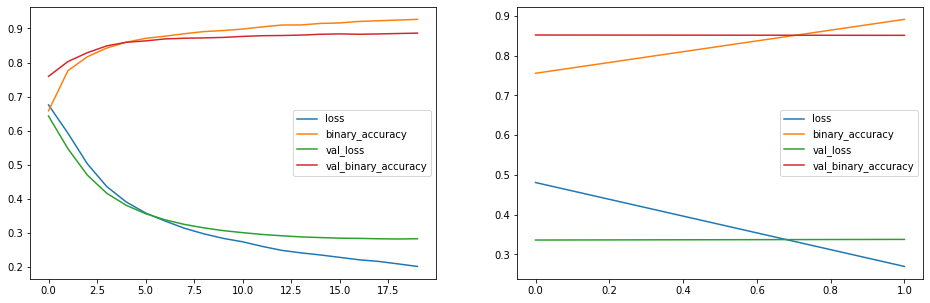

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
model_1_training.plot(ax=ax[0]);
model_2_training.plot(ax=ax[1]);

## Evaluation


In [24]:
loss , accuracy = model_1.evaluate(test_ds)
print('Model 1')
print(f'Loss :{loss} and Accuracy :{accuracy}')

loss , accuracy = model_2.evaluate(test_ds)
print('Model 2')
print(f'Loss :{loss} and Accuracy :{accuracy}')

782/782 [==============================] - 9s 11ms/step - loss: 0.3091 - binary_accuracy: 0.8738
Model 1
Loss :0.30906954407691956 and Accuracy :0.8737599849700928
782/782 [==============================] - 2s 2ms/step - loss: 0.3681 - binary_accuracy: 0.8398
Model 2
Loss :0.3681453466415405 and Accuracy :0.8397600054740906


## Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [25]:
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model_1,
                                    tf.keras.layers.Activation('sigmoid')
                                    ])

export_model.compile(optimizer='adam',
                     loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics=['accuracy'])

Test it with `raw_test_ds`, which yields raw strings

In [26]:
loss , accuracy = export_model.evaluate(raw_test_ds)
print('Model 2')
print(f'Loss :{loss} and Accuracy :{accuracy}')

782/782 [==============================] - 9s 11ms/step - loss: 0.3091 - accuracy: 0.8738
Model 2
Loss :0.3090698719024658 and Accuracy :0.8737599849700928


## Inference on new data

In [27]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

In [28]:
preds = export_model.predict(examples)

In [31]:
for review, pred in zip(examples, preds):
  print('Review', review, '\nConfidence',pred,'\n')

Review The movie was great! 
Confidence [0.6212433] 

Review The movie was okay. 
Confidence [0.41879982] 

Review The movie was terrible... 
Confidence [0.31771207] 

